In [1]:
import torch

# Activation and Flow

Each cell has a set of channel equal in length to the kernel (minus 1 for the origin cell) that denote the weight of connecting edges between that cell and the cell offset from the origin by the amounts specified in the kernel.

The kernel is to be symmetric and start with the origin [0,0]. This means that by rolling the non-origin kernel by half of its length (length(kernel)-1) leaves the offsets in the order of their inverses. This mirrors a kernel. 

Each cell generates a single activation (though it is easy to allow for len(kernel) activations). This activation is positive or negative, as are the weights. If the result of multiplying the activation by the weights is negative, this indicates inverted flow (taking from a neighbor). To compute this, we can simply roll all negative flows such that they are in inverted positions and subtract (so add) them from the flows of their neighbors in the inverted direction (taking from your neighbor is the same as them giving something to you). 

At this point, the flow tensor should only include positive flows and previously negative flows should be set to 0. With this, we can evenly distribute the capital of each cell across its flows and update the capital of each cells' neighbors. This doesn't necessitate that all capital be moved from the cell, the activation could be small and flows associated with the origin (position 0) could be high, meaning capital is given to yourself in the next timestep.  

In [212]:
# Define the kernel and world tensors
# Each kernel element is a shift along the 0 and 1 axes of the world for each channel/layer
kernel = torch.tensor([
    [0, 0],     # ORIGIN
    [0, 1.0],   # (RIGHT)
    [1, 0],     # (DOWN)
    [0, -1],    # (LEFT)
    [-1, 0]     # (UP)
])

muscle_radii = torch.tensor([
    [[-1,  1, 0],      # (0,0) ORIGIN
     [-0.8,  0.8, 0],  
     [0, 0, 0]],  

    [[-0.6, 0.6, 0],    # (0,1) RIGHT
     [-0.4, 0.4, 0],   
     [0, 0, 0]],   

    [[-0.2, 0.2, 0],    # (1,0) DOWN
     [0, 0, 0],
     [0, 0, 0]],
    
    [[0.2, -0.2, 0],    # (0,-1) LEFT
     [0.4, -0.4, 0],
     [0, 0, 0]],
    
    [[0.6, -0.6, 0],    # (-1,0) UP
     [0.8, -0.8, 0],
     [0, 0, 0]]
])

activations = torch.tensor([
    [1, 1, 0],
    [1, 1, 0],
    [0, 0, 0]
])

capital = torch.tensor([
    [4, 3.0, 0],
    [2, 1, 0],
    [0, 0, 0]
])
before = capital.clone()

flow_efficiency = torch.tensor([
    [0.8, 0.8, 0.8],
    [0.8, 0.8, 0.8],
    [0.8, 0.8, 0.8]
])

def activate_muscles_and_flow(capital, muscle_radii, activations, flow_efficiency, kernel):
    total_capital_before = capital.sum()
    assert capital.min() >= 0, "Capital cannot be negative"

    # Invert negative flows across kernel
    roll_shift = (len(kernel)-1)//2
    zero_tensor = torch.tensor([0.0])
    flows = (torch.sign(muscle_radii) * (muscle_radii ** 2)).mul(activations)    # Activation is a percentage (kinda) of CSA
    positive_flows = torch.where(flows[1:] > 0, flows[1:], zero_tensor)
    negative_flows = torch.where(flows[1:] < 0, flows[1:], zero_tensor)
    flows[1:] = positive_flows.sub(torch.roll(negative_flows, roll_shift, dims=0))
    flows[0] = torch.abs(flows[0])

    # Distribute cytoplasm across flows
    total_flow_desired = torch.sum(flows, dim=0)
    total_flow_desired_safe = torch.where(total_flow_desired == 0, torch.tensor(1.0), total_flow_desired)
    flow_distribution = flows.div(total_flow_desired_safe.unsqueeze(0))
    del total_flow_desired_safe

    total_capital_outflow = torch.where(total_flow_desired > capital, capital, total_flow_desired)
    capital.sub_(total_capital_outflow)
    assert capital.min() >= 0, "Capital cannot be negative"
    total_capital_outflow.mul_(flow_efficiency)
    torch.mul(total_capital_outflow.unsqueeze(0), flow_distribution, out=flows)

    # Exchange capital according to the kernel
    capital.add_(
        torch.sum(
            torch.stack(
                [torch.roll(flows[i], shifts=tuple(map(int, kernel[i])), dims=[0, 1]) for i in range(kernel.shape[0])]
            ), dim=0
        )
    )
    capital = torch.where(capital < 0.001, torch.tensor(0.0), capital)
    assert total_capital_before >= capital.sum(), "Capital must be lost in the system"

    return capital


In [ ]:

# weights[1:].sub(torch.roll(torch.where(weights[1:]<0, weights[1:], torch.tensor([0])), (len(kernel)-1)//2, dims=0))

def flow(activations, weights, kernel):
    if not torch.eq(kernel[0], torch.zeros(kernel.shape[1])).all():
        raise ValueError("The first kernel must be the origin.")

    roll_shift = (len(kernel)-1)//2

    if not torch.eq(torch.roll(kernel[1:], roll_shift, dims=0), -kernel[1:]).all():
        raise ValueError("The kernel must be symmetric (excluding the origin).")
    zero_tensor = torch.tensor([0])
    activated_weights = weights.mul(activations)

    activated_weights[1:].sub_(
        torch.roll(
            torch.where(activated_weights[1:] < 0, activated_weights[1:], zero_tensor),
            roll_shift,
            dims=0
        )
    )
    
    activated_weights[0] = torch.abs(activated_weights[0]) # connections to the origin cell are always positive
    
    return 



In [366]:
t = torch.tensor([
    [[ 1,  2,  3],
    [ 4,  5,  6],
    [ 7,  8,  9]],

    [[10, 11, 12],
    [13, 14, 15],
    [16, 17, 18]]])

t1 = torch.stack((torch.roll(t[0],1,1), torch.roll(t[1],1,0)), dim=0)

offsets = torch.tensor([
    [1, 0],
    [0, 1]
])
torch.stack([torch.roll(t[i], shifts=offsets[i].tolist(), dims=[0, 1]) for i in range(t.shape[0])]) 

tensor([[[ 7,  8,  9],
         [ 1,  2,  3],
         [ 4,  5,  6]],

        [[12, 10, 11],
         [15, 13, 14],
         [18, 16, 17]]])

In [334]:
x = torch.tensor([[1,2,3,4,5],
                  [6,7,8,9,10]])

x.unfold(1,2,2)

tensor([[[1, 2],
         [3, 4]],

        [[6, 7],
         [8, 9]]])

In [315]:
# 3d tensor of von neuman 
# kernel_3d = torch.tensor([
#     [ 0,  0,  0],
#     [ 0,  0,  1],
#     [ 0,  1,  0],
#     [ 1,  0,  0],
#     [ 0,  0, -1],
#     [ 0, -1,  0],
#     [-1,  0,  0]])
# flow(1,2,kernel_3d)

flow(activations, muscle_radii, kernel)

# Muscle Growth

Cell growth in EINCASM requires an exchange of a cell's capital to slowly adjust the magnitude of a muscle oriented in a specific direction. If the change in magnitude of a muscle is positive, capital is taken from the cell with an adjustment for "heat loss" reflecting the efficiency of the process. If the change in magnitude is negative, capital, minus a loss, is returned to the cell. 

Muscles, as explained in #Activation and Flow, have an orientation and can be positive or negative. They are encoded in the world tensor as a set of channels where each is associated via order of index with the kernel, which contains offsets. If EINCASM is set up to only have a singular positive or negative activation per cell, then negative and positive muscles always have inverted flows in respect to each other. Because a cell can only change its muscle weights slowly and at a cost of wasted capital, it is to their advantage to choose an orientation and stick to it. 

There a multiple ways muscle growth can be accounted for in EINCASM. The default set up is to have the muscle channels denote the radius and charge of a muscle fiber. The output of the physiology of each cell indicates a change in radius, but the cost of growth is proportional to the cross-sectional area of the new muscle radius minus the original. This set up is chosen to enable flexibilty at a wider range of muscle magnitude scales without drastic changes to weights within the physiology (a neural network). The same cell that controls the small, exploratory muscle fibers/transport tubes can control the very large, established muscles next to large nutrient sources. 

### CODE

In [79]:

# rads_batch = torch.tensor([[-1, 2], [-4, 1], [1, 2], [4, 5]], dtype=torch.float32)
muscle_radii = torch.tensor([
    [[0,  0],      # (0,0) ORIGIN
    [0,  0]],  

   [[-1, -4.0],    # (0,1) UP
    [1, 4]],   

   [[2, 1],    # (1,0) RIGHT
    [2, 5]],
    
   [[0.0, 0.0],    # (0,-1) DOWN
    [0.0, 0.0]],
    
   [[0.0, 0.0],    # (-1,0) LEFT
    [0.0, 0.0]]
])


# rad_deltas_batch = torch.tensor([[1, 1], [2, -1], [-3, -4], [1, 2]], dtype=torch.float32)
radii_deltas = torch.tensor([
    [[0, 0],   # (0,0) ORIGIN
    [0, 0]],

    [[1.0, 2.0],    # (0,1) UP
    [-3.0, 1.0]],

    [[1.0, -1.0],    # (1,0) RIGHT
    [-4.0, 2.0]],

    [[0.0, 0.0],    # (0,-1) DOWN
    [0.0, 0.0]],

    [[0.0, 0.0],    # (-1,0) LEFT
    [0.0, 0.0]]
])     

# capital_batch = torch.tensor([5.0, 3.0, 4.0, 10.0], dtype=torch.float32)
capital = torch.tensor([
    [5.0, 3.0],
    [4.0, 10.0]
])

# efficiency_batch = torch.tensor([0.8, 0.85, 0.9, 1.0], dtype=torch.float32)
growth_efficiency = torch.tensor([
    [0.8, 0.85],
    [0.9, 1.0]
])

def new_grow(muscle_radii, radii_deltas, capital, growth_efficiency):
    zero_tensor = torch.tensor(0.0)
    csa_deltas = (muscle_radii + radii_deltas)**2 - muscle_radii**2  # cross-sectional area
    print(csa_deltas[[1,2]])

    negative_csa_deltas = torch.where(csa_deltas < 0, csa_deltas, zero_tensor)
    positive_csa_deltas = torch.where(csa_deltas > 0, csa_deltas, zero_tensor)

    # Atrophy muscle and convert to capital
    capital.sub_(torch.sum(negative_csa_deltas, dim=0) * growth_efficiency)

    new_csa_mags = muscle_radii**2.0
    new_csa_mags.add_(negative_csa_deltas)

    # Grow muscle from capital, if possible
    capital_desired = torch.sum(positive_csa_deltas, dim=0)
    capital_desired_safe = torch.where(capital_desired == 0, torch.tensor(1.0), capital_desired)
    csa_delta_distribution = positive_csa_deltas / capital_desired_safe.unsqueeze(0) 
    del capital_desired_safe # TODO: Free CUDA memory? Garbage Collect?  

    capital_consumed = torch.where(capital_desired > capital, capital, capital_desired)
    capital.sub_(capital_consumed)
    capital_consumed.mul_(growth_efficiency)
    new_csa_mags.addcmul_(capital_consumed.unsqueeze(0), csa_delta_distribution)
    torch.mul(torch.sqrt(new_csa_mags), torch.sign(muscle_radii + radii_deltas), out=muscle_radii)  

    return muscle_radii, capital

muscle_radii, capital = new_grow(muscle_radii, radii_deltas, capital, growth_efficiency)

print(muscle_radii[[1,2]])
print(capital)

tensor([[[ -1., -12.],
         [  3.,   9.]],

        [[  5.,  -1.],
         [  0.,  24.]]])
tensor([[[ 0.0000, -2.0000],
         [-1.9235,  4.3275]],

        [[ 2.8284,  0.0000],
         [-2.0000,  5.6809]]])
tensor([[ 0.8000, 14.0500],
        [ 1.0000,  0.0000]])


### TESTS

In [81]:
from typing import Tuple

# THIS IS A BATCHED VERSION OF GROW MUSCLE  -- DEPRECATED
# batches of cells, not batches of environments
rads_batch = torch.tensor([[-1, 2], [-4, 1], [1, 2], [4, 5]], dtype=torch.float32)
rad_deltas_batch = torch.tensor([[1, 1], [2, -1], [-3, -4], [1, 2]], dtype=torch.float32)
capital_batch = torch.tensor([5.0, 3.0, 4.0, 10.0], dtype=torch.float32)
efficiency_batch = torch.tensor([0.8, 0.85, 0.9, 1.0], dtype=torch.float32)

def grow_muscle_batch_csa(radii: torch.Tensor, radii_deltas: torch.Tensor,
                capital: torch.Tensor, efficiency: torch.Tensor
                ) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Function to simulate the growth of muscle tissue. Modifies the radii and capital tensors in-place.

    Parameters:
    radii (torch.Tensor): The radii of the muscles of each cell. Shape: (batch_size, num_muscles)
    radii_deltas (torch.Tensor): Desired changes in radii. Shape: (batch_size, num_muscles)
    capital (torch.Tensor): capital present on each cell. Shape: (batch_size,)
    efficiency (torch.Tensor): The efficiency (heat loss) for a given change in muscle size. Shape: (batch_size,)

    Returns:
    Tuple[torch.Tensor, torch.Tensor]: The new muscle radii and capital for
      each cell. Shape: ((batch_size, num_muscles), (batch_size,))
    """
    zero_tensor = torch.tensor(0.0)
    csa_deltas = (radii + radii_deltas)**2 - radii**2  # cross-sectional area
    print(csa_deltas)
    negative_csa_deltas = torch.where(csa_deltas < 0, csa_deltas, zero_tensor)
    positive_csa_deltas = torch.where(csa_deltas > 0, csa_deltas, zero_tensor)

    # Atrophy muscle and convert to capital
    capital.sub_(torch.sum(negative_csa_deltas, dim=1) * efficiency)
    
    new_csa_mags = radii**2.0
    new_csa_mags.add_(negative_csa_deltas)

    # Grow muscle from capital, if possible
    capital_desired = torch.sum(positive_csa_deltas, dim=1)
    capital_desired_safe = torch.where(capital_desired == 0, torch.tensor(1.0), capital_desired)
    csa_delta_distribution = positive_csa_deltas / capital_desired_safe.unsqueeze(1) 
    del capital_desired_safe # TODO: Free CUDA memory? Garbage Collect?  

    capital_consumed = torch.where(capital_desired > capital, capital, capital_desired)
    capital.sub_(capital_consumed)
    capital_consumed.mul_(efficiency)
    new_csa_mags.addcmul_(capital_consumed.unsqueeze(1), csa_delta_distribution)
    torch.mul(torch.sqrt(new_csa_mags), torch.sign(radii + radii_deltas), out=radii)  

    return radii, capital

radii_b, capital_b = grow_muscle_batch_csa(rads_batch, rad_deltas_batch, capital_batch, efficiency_batch)

radii_b.t().reshape(2,2,2)
# print(f"radii:        {out[0]}, batch: {rads_batch}")
# print(f"capital:    {out[1]}, batch: {capital_batch}")
# print("radii_deltas:", rad_deltas_batch)
# print("capital:   ", capital_batch)

tensor([[ -1.,   5.],
        [-12.,  -1.],
        [  3.,   0.],
        [  9.,  24.]])


tensor([[[ 0.0000, -2.0000],
         [-1.9235,  4.3275]],

        [[ 2.8284,  0.0000],
         [-2.0000,  5.6809]]])

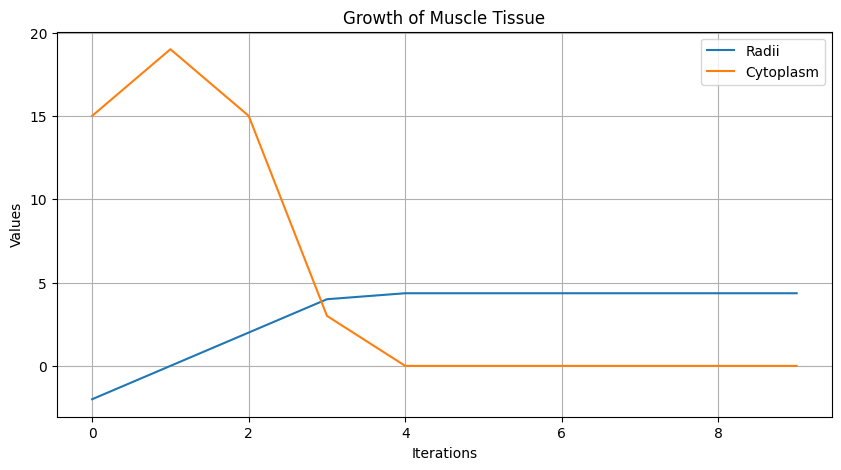

In [247]:
import matplotlib.pyplot as plt

rads_batch = torch.tensor([[-4]], dtype=torch.float32)
rad_deltas_batch = torch.tensor([[2]], dtype=torch.float32)
capital_batch = torch.tensor([3.0], dtype=torch.float32)
efficiency_batch = torch.tensor([1.0], dtype=torch.float32)

radii_results = []
capital_results = []
for _ in range(10):
    out = grow_muscle_batch_csa(rads_batch, rad_deltas_batch, capital_batch, efficiency_batch)
    radii_results.append(out[0].item())
    capital_results.append(out[1].item())

assert torch.isclose(rads_batch, torch.tensor([[4.358899]], dtype=torch.float32), atol=1e-6).all()
assert torch.isclose(capital_batch, torch.tensor([0.0], dtype=torch.float32), atol=1e-6).all()

plt.figure(figsize=(10, 5))
plt.plot(radii_results, label='Radii')
plt.plot(capital_results, label='capital')
plt.xlabel('Iterations')
plt.ylabel('Values')
plt.title('Growth of Muscle Tissue')
plt.legend()
plt.grid(True)
plt.show()